In [1]:
from database.market import Market
from database.sec import SEC
from database.adatabase import ADatabase
import pandas as pd
import matplotlib.pyplot as plt
from processor.processor import Processor as p
from statistics import variance
from tqdm import tqdm
from modeler.modeler import Modeler as m
from datetime import datetime, timedelta

In [2]:
market = Market()

In [202]:
market.connect()
prices = market.retrieve("prices")
market.disconnect()

In [3]:
main_db = ADatabase("strat_eg")

In [203]:
prices = p.column_date_processing(prices)
prices["year"] = [x.year for x in prices["date"]]
prices["week"] = [x.week for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]

In [239]:
main_db.connect()
t = main_db.retrieve("trades_siloed_market_corr")
main_db.disconnect()

In [240]:
t["delta"] =  (t["sell_price"] - t["adjclose"]) / t["adjclose"]

In [241]:
analysis = []
positions = 5
for strat in ["financial","speculation"]:
    for position in range(positions):
        position_trades = t[(t["position"]==position) \
                            & (t["strat"]==strat) \
                           ].sort_values("date")
        position_trades["delta"] = (position_trades["sell_price"] - position_trades["adjclose"]) / position_trades["adjclose"]
        initial = 100 / positions
        for delta in position_trades["delta"]:
            initial = initial * (1+delta)
        analysis.append({
            "position":position,
            "strat": strat,
            "pv":initial
        })

In [242]:
a = pd.DataFrame(analysis)

In [243]:
a

,position,strat,pv
0,0,financial,33.897667
1,1,financial,24.159593
2,2,financial,98.198220
3,3,financial,25.741787
4,4,financial,23.222854
5,0,speculation,56.019369
6,1,speculation,56.279285
7,2,speculation,74.859133
8,3,speculation,69.714749
9,4,speculation,41.554846


In [244]:
complete = a.pivot_table(index=[x for x in a.columns if x != "pv" and x != "position"],columns="position",values="pv").reset_index()

In [245]:
complete["pv"] = [sum([row[1][i] for i in range(positions)]) for row in complete.iterrows()]

In [246]:
complete.sort_values("pv",ascending=False).head(10)

position,strat,0,1,2,3,4,pv
1,speculation,56.019369,56.279285,74.859133,69.714749,41.554846,298.427382
0,financial,33.897667,24.159593,98.198220,25.741787,23.222854,205.220121


In [247]:
t["count"] = 1
market.connect()
sp5 = market.retrieve("sp500")
market.disconnect()
industries = list(sp5["GICS Sector"].unique())

In [248]:
dash = t.groupby(["position","strat"]).agg({"adjclose":"mean","delta":"mean","count":"sum"}).reset_index()
dash.sort_values("delta",ascending=False)

,position,strat,adjclose,delta,count
4,2,financial,13.923467,3.909911,1
0,0,financial,9.216057,0.694883,1
6,3,financial,17.372452,0.287089,1
2,1,financial,13.346372,0.207980,1
5,2,speculation,58.908866,0.207223,9
3,1,speculation,189.258404,0.174267,7
1,0,speculation,183.138467,0.162015,7
8,4,financial,15.108571,0.161143,1
7,3,speculation,85.999589,0.128039,17
9,4,speculation,181.471309,0.058304,20


In [249]:
t

,date,ticker,adjclose,financial_delta,speculation_delta,sell_price,sell_date,position,strat,delta,count
0,2020-01-02,F,9.216057,4.257740,-0.006839,15.620142,2021-10-15,0,financial,0.694883,1
1,2020-01-02,MRO,13.346372,4.132498,-0.000500,16.122145,2021-10-15,1,financial,0.207980,1
2,2020-01-02,BBWI,13.923467,3.909911,0.039864,68.362986,2021-08-27,2,financial,3.909911,1
3,2020-01-02,NWL,17.372452,3.786434,-0.017651,22.359898,2021-10-15,3,financial,0.287089,1
4,2020-01-02,PBCT,15.108571,3.709301,-0.001651,17.543207,2021-10-15,4,financial,0.161143,1
...,...,...,...,...,...,...,...,...,...,...,...
60,2021-06-08,HOLX,60.520000,0.327743,0.044595,63.218914,2021-06-11,4,speculation,0.044595,1
61,2021-06-14,CNC,68.780000,2.597512,0.033117,71.057767,2021-06-16,4,speculation,0.033117,1
62,2021-06-17,C,67.844238,0.462185,0.046250,70.982019,2021-08-09,4,speculation,0.046250,1
63,2021-08-10,MKTX,466.793243,-0.432599,0.032534,481.979858,2021-08-27,4,speculation,0.032534,1


In [250]:
report = []
best_iteration = t.sort_values("date")
stuff = []
initial = 100
if best_iteration.index.size > 0:
    for strat in tqdm(["financial","speculation"]):
        for position in best_iteration["position"].unique():
            pv = 100 / positions
            risk_set = []
            position_trades = best_iteration[(best_iteration["position"]==position) & (best_iteration["strat"]==strat)].sort_values("date")
            for i in range(position_trades.index.size):
                trade = position_trades.iloc[i]
                holding_days = int((trade["sell_date"]-trade["date"]).days)
                for i in range(holding_days+1):
                    updated_date = trade["date"] + timedelta(days=i)
                    risk_set.append({"ticker":trade["ticker"],"date":updated_date,"position":position})
                mem = pd.DataFrame(risk_set)
                price_data = prices[(prices["ticker"]==trade["ticker"]) & (prices["date"]>=trade["date"]) & (prices["date"]<=trade["sell_date"])][["date","ticker","adjclose"]].copy()
                merged_mem = mem.merge(price_data,on=["date","ticker"],how="left").dropna()
                merged_mem.sort_values("date",inplace=True)
                if trade["delta"] > 0:
                    new_closes = list(merged_mem["adjclose"].iloc[:-1])
                    new_closes.append(trade["sell_price"])
                    merged_mem["adjclose"] = new_closes
                volume = pv /merged_mem.iloc[0]["adjclose"] 
                merged_mem["volume"] = volume
                merged_mem["pv"] = merged_mem["adjclose"] * merged_mem["volume"]
                pv = merged_mem["pv"].iloc[-1]
                stuff.append(merged_mem)
        test = pd.concat(stuff)
        whut = test.pivot_table(index="date",columns="position",values="pv").fillna(method="ffill").reset_index()
        for i in range(positions):
            if i not in whut.columns:
                whut[i] = 100/positions
        whut["pv"] = [sum([row[1][i] for i in range(positions)]) for row in whut.iterrows()]
        whut["rolling"] = whut["pv"].rolling(window=100).mean()
        whut["abs_var"] = abs(whut["pv"] - whut["rolling"]) / whut["rolling"]
        whut["abs_var"].mean()
        whut["strat"] = strat
        report.append(whut[["date","pv","abs_var","strat"]])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.84s/it]


In [251]:
whut

position,date,0,1,2,3,4,pv,rolling,abs_var,strat
0,2020-01-02,20.000000,20.000000,20.000000,20.000000,20.000000,100.000000,NaN,NaN,speculation
1,2020-01-03,19.699377,20.077530,21.181948,20.067637,19.950739,100.977231,NaN,NaN,speculation
2,2020-01-06,19.661697,20.236311,20.781719,20.193423,19.941561,100.814712,NaN,NaN,speculation
3,2020-01-07,19.825832,20.086341,20.817370,20.346754,19.760928,100.837224,NaN,NaN,speculation
4,2020-01-08,20.028814,19.578434,21.120329,20.559596,19.730632,101.017805,NaN,NaN,speculation
...,...,...,...,...,...,...,...,...,...,...
499,2021-12-23,54.642865,54.646407,74.859133,69.714749,41.554846,295.418000,252.288156,0.170955,speculation
500,2021-12-27,55.431624,55.833698,74.859133,69.714749,41.554846,297.394050,253.055826,0.175211,speculation
501,2021-12-28,55.501541,55.094814,74.859133,69.714749,41.554846,296.725084,253.783333,0.169206,speculation
502,2021-12-29,56.277191,55.692690,74.859133,69.714749,41.554846,298.098609,254.520096,0.171218,speculation


In [252]:
report_df = pd.concat(report)

In [253]:
report_df.groupby("strat").agg({"pv":"last","abs_var":"mean"}).sort_values("pv",ascending=False)

position,pv,abs_var
strat,,
speculation,298.427382,0.162097
financial,205.220121,0.162340


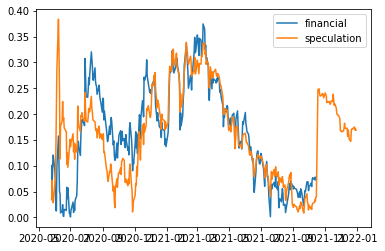

In [254]:
for strat in ["financial","speculation"]:
    whut = report_df[report_df["strat"]==strat]
    plt.plot(whut["date"],whut["abs_var"])
plt.legend(["financial","speculation"])

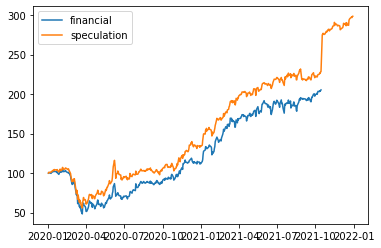

In [255]:
for strat in ["financial","speculation"]:
    whut = report_df[report_df["strat"]==strat]
    plt.plot(whut["date"],whut["pv"])
plt.legend(["financial","speculation"])